In [1]:
import sys
import os

from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. '/Users/darren/Documents/CSE493G1/GuitarTransformer/'
FOLDERNAME = 'drive/MyDrive/project/GuitarTransformer'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Add the root directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

print(os.getcwd())

%cd $FOLDERNAME

Mounted at /content/drive
/content
/content/drive/MyDrive/project/GuitarTransformer


In [2]:
! pip3 install -r pip-requirement.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.7 MB/s eta 0:00:00
  Created wheel for sox: filename=sox-1.5.0-py3-none-any.whl size=40037 sha256=a3cb2bfe3c852941bc45f6e6f0ce8e671a5461bc22b6207439067493e28a5282
  Stored in directory: /root/.cache/pip/wheels/74/e7/7b/8033be3ec5e4994595d01269fc9657c8fd83a0dcbf8536666a
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=cc9a8fd8c3b49d9bee1c685c012994b5ff67169e7e3912fa050bdd2eea83ac10
  Stored in directory: /root/.cache/pip/wheels/8e/

In [3]:
import torch
if not torch.cuda.is_available():
    print('cuda device not available/not selected')

else:
    print('cuda device available')


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cuda device available


In [4]:
# model definition, seq2seq stateful lstm for real-time audio processing

import math
import torch
import torch.optim as optim
import torch.nn as nn

class AudioLSTM(nn.Module):
  def __init__(self, input_size, output_size, hidden_size, skip=1, num_layers=1):
    super(AudioLSTM, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.skip = skip

    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

    # needed for stateful LSTM
    self.hidden = None  # (hidden state, cell state)

  def forward(self, x):
    """
    :param x: tensor of shape (batch_size, seq_length, features)
    """
    if self.hidden is None:
      self.hidden = (
        torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device),
        torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
      )

    out, self.hidden = self.lstm(x, self.hidden)

    out = self.fc(out)

    # add residual step
    if self.skip:
      out += x[:, :, :]

    return out

  def reset_hidden(self):
    self.hidden = None

  # detach hidden state, this resets gradient tracking on the hidden state
  def detach_hidden(self):
    if self.hidden.__class__ == tuple:
      self.hidden = tuple([h.clone().detach() for h in self.hidden])
    else:
      self.hidden = self.hidden.clone().detach()

  def train_epoch(self, input_data, target_data, loss_fcn, optim, bs, init_len=200, up_fr=1000):
    """
    :param input_data: x examples with shape (num_examples, seq_length, features)
    :param target_data: y target with shape (num_examples, seq_length, features)
    :param loss_fcn: our loss function
    :param optim: our optimizer
    :param bs: batch size, number of examples per batch
    :param init_len: number of audio samples to initialize hidden state
    :param up_fr: number of timesteps before we backprop (truncated backprop)
    """
    # shuffle the examples around
    shuffle = torch.randperm(input_data.shape[0], device=input_data.device)

    # Iterate over the batches
    ep_loss = 0
    for batch_i in range(math.ceil(shuffle.shape[0] / bs)):
      # Load batch of shuffled segments
      input_batch = input_data[shuffle[batch_i * bs:(batch_i + 1) * bs], :, :].to(device)
      target_batch = target_data[shuffle[batch_i * bs:(batch_i + 1) * bs],:, :].to(device)

      # Initialise network hidden state by processing some samples then zero the gradient buffers
      self(input_batch[:, 0:init_len, :])
      self.zero_grad()

      # Choose the starting index for processing the rest of the batch sequence, in chunks of args.up_fr
      start_i = init_len
      batch_loss = 0
      k = 0
      # Iterate over the remaining samples in the mini batch
      for k in range(math.ceil((input_batch.shape[1] - init_len) / up_fr)):
        # Process input batch with neural network
        input = input_batch[:, start_i:start_i + up_fr, :].to(device)
        output = self(input)

        # Calculate loss and update network parameters
        loss = loss_fcn(output, target_batch[:, start_i:start_i + up_fr, :])
        loss.backward()
        optim.step()

        # Set the network hidden state, to detach it from the computation graph
        self.detach_hidden()
        self.zero_grad()

        # Update the start index for the next iteration and add the loss to the batch_loss total
        start_i += up_fr
        batch_loss += loss

      # Add the average batch loss to the epoch loss and reset the hidden states to zeros
      ep_loss += batch_loss / (k + 1)
      self.reset_hidden()

    return ep_loss / (batch_i + 1)

  def process_data(self, input_data, target_data, loss_function, chuck_size):
    """
    :param input_data: x examples with shape (num_examples, seq_length, features)
    :param target_data: y target with shape (num_examples, seq_length, features)
    :param loss_fcn: our loss function
    :param chuck_size: the number of seq_length to process one time (avoid memory issue)
    """

    with torch.no_grad():
        # calculate the number of processing
        frame_len = target_data.size()[1]
        chuck_num = math.ceil(frame_len / chuck_size)

        # create empty output tensor
        output = torch.empty_like(target_data)

        # Iterate over chucks and process the input audio
        for l in range(chuck_num):
            # forward the input
            if l == chuck_num - 1: # the last loop
                output[:, l * chuck_size:, :] = self(input_data[:, l * chuck_size:, :])
            else: # before the last loop
                output[:, l * chuck_size:(l + 1) * chuck_size, :] = self(input_data[:, l * chuck_size:(l + 1) * chuck_size, :])
            self.detach_hidden()
        self.reset_hidden()

        # calucate the loss
        loss = loss_function(output, target_data)
    return output, loss


In [5]:
# The loss function used in Alec's paper. However, it currently only supports for single channel.

class ESRLoss(nn.Module):
    def __init__(self):
        super(ESRLoss, self).__init__()
        self.epsilon = 0.00001

    def forward(self, output, target):
        loss = torch.add(target, -output).to(output.device)
        loss = torch.pow(loss, 2)
        loss = torch.mean(loss)
        energy = torch.mean(torch.pow(target, 2)) + self.epsilon
        loss = torch.div(loss, energy)
        return loss


class DCLoss(nn.Module):
    def __init__(self):
        super(DCLoss, self).__init__()
        self.epsilon = 0.00001

    def forward(self, output, target):
        loss = torch.pow(torch.add(torch.mean(target, 0), -torch.mean(output, 0)), 2).to(output.device)
        loss = torch.mean(loss)
        energy = torch.mean(torch.pow(target, 2)) + self.epsilon
        loss = torch.div(loss, energy)
        return loss


# PreEmph is a class that applies an FIR pre-emphasis filter to the signal, the filter coefficients are in the
# filter_cfs argument, and lp is a flag that also applies a low pass filter
# Only supported for single-channel!
class PreEmph(nn.Module):
    def __init__(self, filter_cfs, low_pass=0):
        super(PreEmph, self).__init__()
        self.epsilon = 0.00001
        self.zPad = len(filter_cfs) - 1

        self.conv_filter = nn.Conv1d(1, 1, 2, bias=False)
        self.conv_filter.weight.data = torch.tensor([[filter_cfs]], requires_grad=False).to(device)

        self.low_pass = low_pass
        if self.low_pass:
            self.lp_filter = nn.Conv1d(1, 1, 2, bias=False)
            self.lp_filter.weight.data = torch.tensor([[[0.85, 1]]], requires_grad=False).to(device)

    def forward(self, output, target):
        # zero pad the input/target so the filtered signal is the same length
        output = torch.cat((torch.zeros(self.zPad, output.shape[1], 1).to(output.device), output))
        target = torch.cat((torch.zeros(self.zPad, target.shape[1], 1).to(target.device), target))

        # Apply pre-emph filter, permute because the dimension order is different for RNNs and Convs in pytorch...
        output = self.conv_filter(output.permute(1, 2, 0))
        target = self.conv_filter(target.permute(1, 2, 0))

        if self.low_pass:
            output = self.lp_filter(output)
            target = self.lp_filter(target)

        return output.permute(2, 0, 1), target.permute(2, 0, 1)

class LossWrapper(nn.Module):
    def __init__(self, losses, pre_filt=None):
        super(LossWrapper, self).__init__()
        loss_dict = {'ESR': ESRLoss(), 'DC': DCLoss()}
        if pre_filt:
            pre_filt = PreEmph(pre_filt)
            loss_dict['ESRPre'] = lambda output, target: loss_dict['ESR'].forward(*pre_filt(output, target))
        loss_functions = [[loss_dict[key], value] for key, value in losses.items()]

        self.loss_functions = tuple([items[0] for items in loss_functions])
        try:
            self.loss_factors = tuple(torch.Tensor([items[1] for items in loss_functions]))
        except IndexError:
            self.loss_factors = torch.ones(len(self.loss_functions))

    def forward(self, output, target):
        loss = 0
        for i, losses in enumerate(self.loss_functions):
            loss += torch.mul(losses(output, target), self.loss_factors[i]).to(device)
        return loss

In [28]:
import audio

amplifier = 'muff'

# load data
def audio_preprocessing(amplifier, data_type='train', frame_len=1):

    assert amplifier in ('ht1', 'muff') , "Amplifier should be either ht1 or muff"
    assert data_type in ('train', 'val', 'test') , "data_type should be either train , val or test"

    input_loc = f'./data/{data_type}/{amplifier}-input.wav'
    target_loc = f'./data/{data_type}/{amplifier}-target.wav'

    input_waveform = audio.load_audio(input_loc)
    target_waveform = audio.load_audio(target_loc)

    input_frames = audio.framify(input_waveform, frame_len)
    target_frames = audio.framify(target_waveform, frame_len)

    if data_type == 'train':
        seq_length = 22050
        X = audio.split_data(input_frames, seq_length).to(device)
        y = audio.split_data(target_frames, seq_length).to(device)

    else:
        frame_len = input_frames.shape[0]
        seq_length = frame_len//1
        X = audio.split_data(input_frames, seq_length).to(device)
        y = audio.split_data(target_frames, seq_length).to(device)

    return X, y

X_train, y_train = audio_preprocessing(amplifier=amplifier, data_type='train')
X_val, y_val = audio_preprocessing(amplifier=amplifier, data_type='val')
X_test, y_test = audio_preprocessing(amplifier=amplifier, data_type='test')


In [29]:
print('training:', X_train.shape, y_train.shape)
print('validation: ', X_val.shape, y_val.shape)
print('test: ', X_test.shape, y_test.shape)

training: torch.Size([680, 22050, 1]) torch.Size([680, 22050, 1])
validation:  torch.Size([1, 2251753, 1]) torch.Size([1, 2251753, 1])
test:  torch.Size([1, 2646001, 1]) torch.Size([1, 2646001, 1])


In [42]:
import numpy as np
import random

# model params
input_size = 1  # num features, 2 for stereo
output_size = 1  # num features, 2 for stereo
hidden_size = 16  # hidden state size
skip_con = 1  # is there a skip connection?

# train params
batch_size = 50  # num examples per batch
init_len = 200  # num frames to process without backprop to init hidden state
up_fr = 1000  # num frames for truncated backprop
epochs = 150 # num epochs

# hyperparams
learn_rate = 5e-3

network = AudioLSTM(input_size=input_size, hidden_size=hidden_size,
                                     output_size=output_size, skip=skip_con).to(device)

# Set up training optimiser + scheduler + loss fcns and training info tracker
optimiser = optim.Adam(network.parameters(), lr=learn_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', factor=0.5, patience=5, verbose=True)
# loss_functions = nn.SmoothL1Loss()

# Use Alec's loss function
loss_fcns = {'ESRPre': 0.75, 'DC': 0.25}
pre_filt = [-0.85, 1] #'high_pass'
loss_functions = LossWrapper(loss_fcns, pre_filt)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [43]:
# TODO: train the model
import time
from collections import defaultdict
import copy

res = defaultdict(list)
best_val_loss = float('inf')
best_model = None
best_ind = -1

# Train epochs
for epoch in range(epochs):

    ep_st_time = time.time()
    # train in training
    epoch_loss = network.train_epoch(X_train, y_train, loss_functions, optimiser, batch_size, init_len, up_fr)
    ep_end_time = time.time()

    val_st_time = time.time()
    # check validation result
    output, val_loss = network.process_data(X_val, y_val, loss_functions, chuck_size=1000)
    val_end_time = time.time()

    # save best model
    if val_loss < best_val_loss :
      best_model = copy.deepcopy(network)
      best_val_loss = val_loss
      best_ind = epoch

    res['epoch'].append(epoch+1)
    res['training_loss'].append(epoch_loss.item())
    res['training_time'].append(ep_end_time - ep_st_time)
    res['val_loss'].append(val_loss.item())
    res['val_time'].append(val_end_time - val_st_time)

    print(f"Epoch {epoch + 1}, Loss: {epoch_loss: .8f}, Val Loss: {val_loss: .8f}")


Epoch 1, Loss:  0.77807659, Val Loss:  1.02670240
Epoch 2, Loss:  0.65323049, Val Loss:  0.90170479
Epoch 3, Loss:  0.43671671, Val Loss:  0.34968123
Epoch 4, Loss:  0.26601282, Val Loss:  0.34453478
Epoch 5, Loss:  0.25819126, Val Loss:  0.34517112
Epoch 6, Loss:  0.25222039, Val Loss:  0.33018270
Epoch 7, Loss:  0.25356436, Val Loss:  0.32973492
Epoch 8, Loss:  0.25418806, Val Loss:  0.35348585
Epoch 9, Loss:  0.24860033, Val Loss:  0.32971415
Epoch 10, Loss:  0.24745858, Val Loss:  0.35745627
Epoch 11, Loss:  0.25404197, Val Loss:  0.33422899
Epoch 12, Loss:  0.24643964, Val Loss:  0.33074668
Epoch 13, Loss:  0.24651471, Val Loss:  0.33406261
Epoch 14, Loss:  0.25078988, Val Loss:  0.35646659
Epoch 15, Loss:  0.24445054, Val Loss:  0.32984614
Epoch 16, Loss:  0.24103598, Val Loss:  0.30284959
Epoch 17, Loss:  0.22661832, Val Loss:  0.32859540
Epoch 18, Loss:  0.20778295, Val Loss:  0.28176770
Epoch 19, Loss:  0.17727858, Val Loss:  0.34705016
Epoch 20, Loss:  0.17544296, Val Loss:  

In [44]:
import pandas as pd
res_table = pd.DataFrame(res)
res_table = res_table[['epoch', 'training_loss', 'val_loss', 'training_time', 'val_time']]

training_time = res_table['training_time'].sum()
print(f'training_time for {epochs} epochs: {training_time} sec')
print(f'best epoch is {best_ind+1}')

training_progress_loc =  f'result/{amplifier}_{hidden_size}_LSTM_training_process.csv'
res_table.to_csv(training_progress_loc, index=False)
res_table

training_time for 150 epochs: 235.27590584754944 sec
best epoch is 150


,epoch,training_loss,val_loss,training_time,val_time
0,1,0.778077,1.026702,1.469242,1.231684
1,2,0.653230,0.901705,1.402985,1.237998
2,3,0.436717,0.349681,1.760812,1.353731
3,4,0.266013,0.344535,1.523455,1.445138
4,5,0.258191,0.345171,1.958912,1.370245
...,...,...,...,...,...
145,146,0.057726,0.237386,1.447387,1.458675
146,147,0.069341,0.076953,1.441019,1.458441
147,148,0.046092,0.060267,1.560846,1.479602
148,149,0.055207,0.075076,1.889856,1.460412


In [45]:
test_st_time = time.time()
output, test_loss = best_model.process_data(X_test, y_test, loss_functions, chuck_size=1000)
test_end_time = time.time()
print(f'test loss: {test_loss:.6f}')
print(f'test time: {test_end_time - test_st_time} sec')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(


test loss: 0.103737
test time: 2.0348386764526367 sec


In [46]:
# save model
import pickle
pickle.dump(best_model, open(f'result/{amplifier}_{hidden_size}_LSTM_model.pkl', 'wb'))

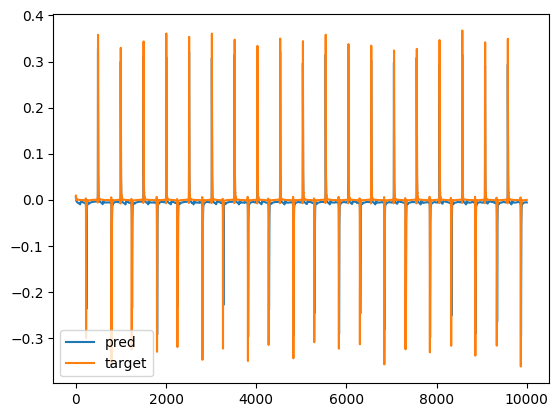

In [47]:
import matplotlib.pyplot as plt
y_test_pred = output[0, :, 0].to('cpu')
y_test_true = y_test[0, :, 0].to('cpu')
plot_range = [200000, 210000]
plt.plot(range(len(y_test_pred[plot_range[0]:plot_range[1]])), y_test_pred[plot_range[0]:plot_range[1]], label='pred')
plt.plot(range(len(y_test_true[plot_range[0]:plot_range[1]])), y_test_true[plot_range[0]:plot_range[1]], label='target')
plt.legend()

In [48]:
# save the

csv_output_name = f'result/{amplifier}_{hidden_size}_LSTM_test_result.csv'

result_df = pd.DataFrame({'y_test_pred' : y_test_pred,
                          'y_test_true' : y_test_true})
result_df.to_csv(csv_output_name, index=False)

In [49]:
import torchaudio

filepath = f"result/{amplifier}_{hidden_size}_LSTM_target_predict.wav"
output1 = output[0].to('cpu')
torchaudio.save(filepath, output1, sample_rate=44100, channels_first=False)